## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator 

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.regularizers import l2
from keras.models import model_from_json
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
59955,00014798_014.png,No Finding,14,14798,23,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014798_014.png
74750,00018360_012.png,Edema|Pneumonia,12,18360,62,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00018360_012.png
89681,00022268_005.png,No Finding,5,22268,60,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00022268_005.png
104345,00027893_002.png,No Finding,2,27893,59,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027893_002.png
64335,00015869_013.png,No Finding,13,15869,45,F,PA,2048,2500,0.168,0.168,NaN,/data/images_007/images/00015869_013.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
107247,00028939_012.png,Infiltration,12,28939,30,M,AP,2544,3056,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
85210,00021006_029.png,Atelectasis|Infiltration|Pneumothorax,29,21006,71,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
10713,00002773_000.png,No Finding,0,2773,21,M,PA,2662,2821,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df.loc[all_xray_df['Pneumonia'] == 0, 'pneumonia_class'] = 'no'
all_xray_df.loc[all_xray_df['Pneumonia'] == 1, 'pneumonia_class'] = 'yes'
all_xray_df[['Pneumonia','pneumonia_class']].head()

,Pneumonia,pneumonia_class
0,0.0,no
1,0.0,no
2,0.0,no
3,0.0,no
4,0.0,no


## Create your training and testing data:

In [6]:
def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['Pneumonia'])
    
    print('train percentage',len(train_df)/len(d))
    print('validation percentage',len(valid_df)/len(d))
    print('length train_df befor', len(train_df))
    print('length validation befor', len(valid_df))
    
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    print('percentage of training data',train_df['Pneumonia'].sum()/len(train_df))
    
    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,1*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    print('percentage of validation data',valid_df['Pneumonia'].sum()/len(valid_df))
    
    print('length train_df After', len(train_df))
    print('length validation After', len(valid_df))
    
    
    return train_df, valid_df

In [7]:
train_data, val_data = create_splits(all_xray_df)

train percentage 0.8
validation percentage 0.2
length train_df befor 89696
length validation befor 22424
percentage of training data 0.5
percentage of validation data 0.5
length train_df After 2290
length validation After 572


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
#IMG_SIZE = (1,224,224,3)
IMG_SIZE = (224,224)

In [9]:
def my_image_augmentation():
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20.0, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    return my_idg


def make_train_gen(my_train_idg, train_df):
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'categorical',
                                         target_size = IMG_SIZE, 
                                         batch_size = 16)
    print(train_gen.class_indices)
    
    return train_gen


def make_val_gen(my_val_idg,val_data ):
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'categorical',
                                             target_size = IMG_SIZE, 
                                             batch_size = 32 )
    print(val_gen.class_indices)
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_val_idg =ImageDataGenerator(rescale=1. / 255.0)
val_gen = make_val_gen(my_val_idg, val_data)
valX, valY = val_gen.next()

Found 572 validated image filenames belonging to 2 classes.
{'no': 0, 'yes': 1}


In [11]:
my_train_idg = my_image_augmentation()
train_gen = make_train_gen(my_train_idg, train_data)

Found 2290 validated image filenames belonging to 2 classes.
{'no': 0, 'yes': 1}


In [12]:
len(train_gen)

144

[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


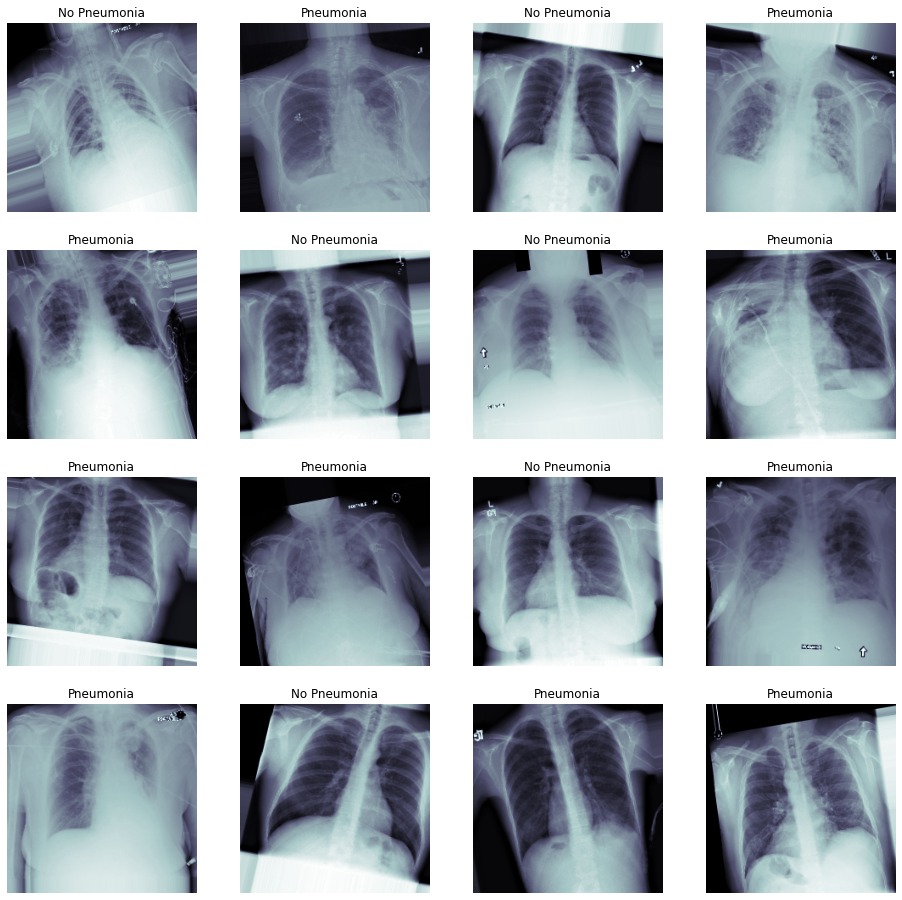

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    print(c_y)
    if c_y[1] == 1: 
        print(c_y)
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [15]:
def load_pretrained_model():
    model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
    #transfer_layer = model.get_layer('block5_pool')
    #vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

    return model


In [16]:
def build_my_model(model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor   
    
    ## Here, we'll freeze all but the last convolutional layer
    
    
    x=Dense(1024, activation='relu')(model.layers[-4].output)# add my own dense layer after the last conv block
    x=Dropout(0.7)(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2,activation='softmax')(x)
    model=Model(model.input,x)
    
    for layer in model.layers[:-10]:#freeze all layers except the last ten
        layer.trainable = False 

    optimizer = Adam(lr=0.0001, decay=1e-5)
    loss = 'binary_crossentropy'
    #metrics = ['binary_accuracy']
    metrics = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)

# Check the trainable status of the individual layers
for layer in my_model.layers:
    print(layer, layer.trainable)
    
my_model.summary()    

<keras.engine.input_layer.InputLayer object at 0x7f5bb4b15650> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b9eb90> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b9ed90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5bb631f090> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b3d0d0> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b54b10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5bb4b5bf10> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b5b910> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b5dfd0> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b66d10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5bb4b66c90> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b6bc50> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4b60fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f5bb4abe350> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5bb4b75d90>

In [16]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'loss', #monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', #mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC,
                             save_weights_only = True)

early = EarlyStopping(monitor= 'loss',  #monitor= SAME_AS_METRIC_CHOSEN_ABOVE,
                       mode= 'auto', #mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC,
                       patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [17]:
## train your model

vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)


history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 15, 
                           callbacks = callbacks_list,class_weight={0:1.0, 1:0.4})

Epoch 1/15
144/144 [==============================] - 66s 459ms/step - loss: 0.4696 - accuracy: 0.5044 - val_loss: 0.9006 - val_accuracy: 0.4375

Epoch 00001: loss improved from inf to 0.46991, saving model to xray_class_my_model.best.hdf5
Epoch 2/15
144/144 [==============================] - 60s 417ms/step - loss: 0.4135 - accuracy: 0.5017 - val_loss: 0.8380 - val_accuracy: 0.4375

Epoch 00002: loss improved from 0.46991 to 0.41360, saving model to xray_class_my_model.best.hdf5
Epoch 3/15
144/144 [==============================] - 60s 417ms/step - loss: 0.4063 - accuracy: 0.5052 - val_loss: 0.8421 - val_accuracy: 0.4375

Epoch 00003: loss improved from 0.41360 to 0.40557, saving model to xray_class_my_model.best.hdf5
Epoch 4/15
144/144 [==============================] - 60s 419ms/step - loss: 0.4006 - accuracy: 0.5031 - val_loss: 0.7666 - val_accuracy: 0.4375

Epoch 00004: loss improved from 0.40557 to 0.40139, saving model to xray_class_my_model.best.hdf5
Epoch 5/15
144/144 [========

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [21]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model_path = "my_model.json"
weight_path = './xray_class_my_model.best.hdf5' #path to saved best weights
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
my_model = model_from_json(loaded_model_json)

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 19s 590ms/step


In [22]:
pred_Y[:,1]

array([0.22294915, 0.42059132, 0.43184856, 0.6299112 , 0.60052097,
       0.24611275, 0.5120151 , 0.40361813, 0.32435703, 0.3723313 ,
       0.096234  , 0.19157842, 0.27462766, 0.6455462 , 0.19850929,
       0.5843583 , 0.48688525, 0.35971212, 0.26820385, 0.32963014,
       0.41800934, 0.52928436, 0.04000018, 0.5201983 , 0.09431046,
       0.3560754 , 0.5419176 , 0.07544102, 0.07511849, 0.38976777,
       0.6000698 , 0.5705248 ], dtype=float32)

In [29]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)


def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return

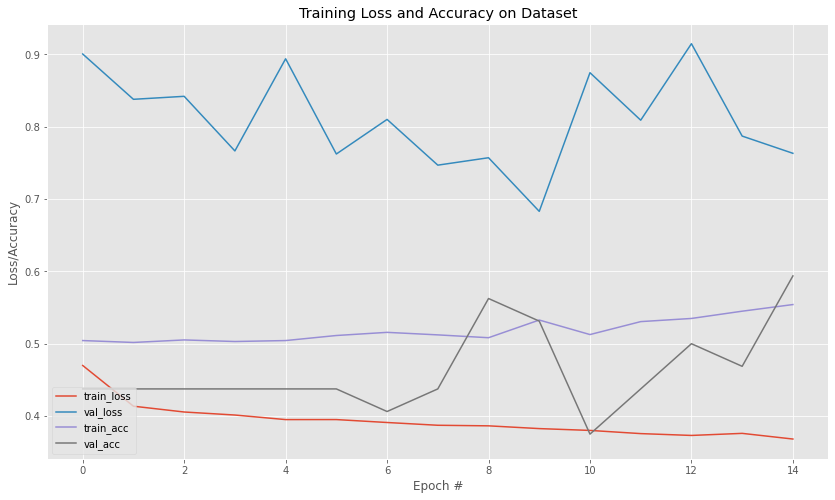

In [34]:
 plot_history(history)

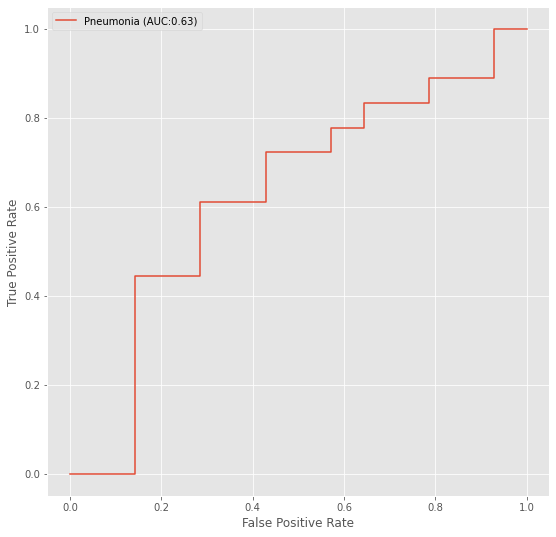

In [35]:
plot_auc(valY[:,1],pred_Y[:,1])

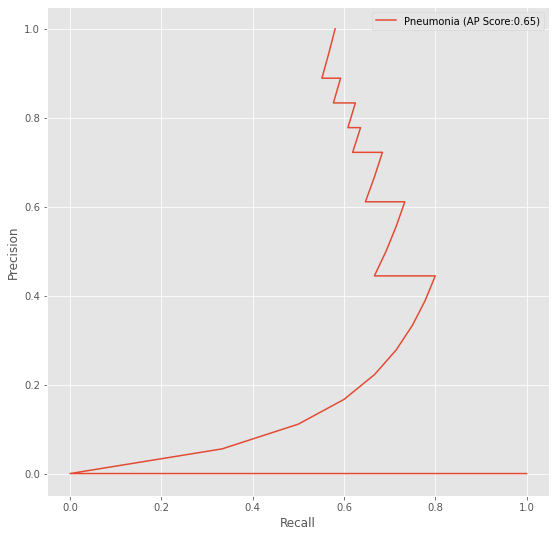

In [36]:
plot_pr(valY[:,1],pred_Y[:,1])

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY[:,1],pred_Y[:,1])

In [24]:
precision

array([0.62068966, 0.60714286, 0.62962963, 0.65384615, 0.68      ,
       0.70833333, 0.73913043, 0.72727273, 0.71428571, 0.75      ,
       0.73684211, 0.72222222, 0.76470588, 0.75      , 0.8       ,
       0.85714286, 0.84615385, 0.83333333, 0.81818182, 0.9       ,
       0.88888889, 0.875     , 0.85714286, 0.83333333, 0.8       ,
       0.75      , 1.        , 1.        , 1.        , 1.        ])

In [39]:

# Get predictions
pred = np.argmax(pred_Y, axis=-1)

# Original labels
labels = np.argmax(valY, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.52      0.79      0.63        14
           1       0.73      0.44      0.55        18

    accuracy                           0.59        32
   macro avg       0.63      0.62      0.59        32
weighted avg       0.64      0.59      0.59        32



In [47]:
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.8
Recall is: 0.4444444444444444
Threshold is: 0.5118308
F1 Score is: 0.5714285714285714


In [41]:
# Look at the threshold where precision is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6086956521739131
Recall is: 0.7777777777777778
Threshold is: 0.24126859
F1 Score is: 0.6829268292682927


FP : 2
TP : 8


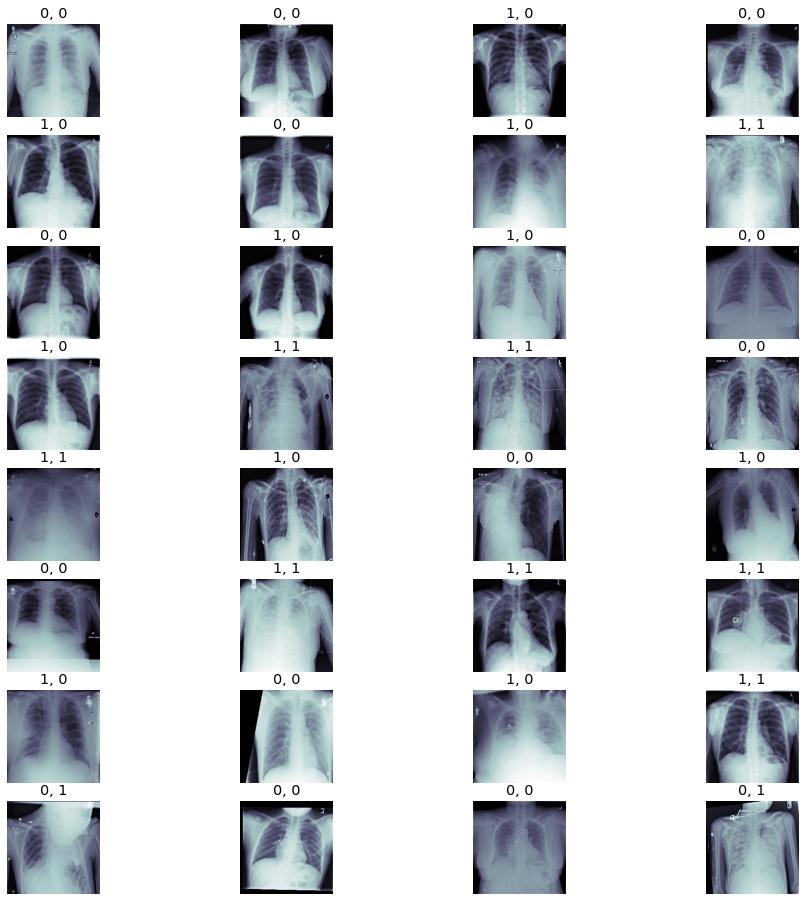

In [54]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo
YOUR_THRESHOLD = 0.5118308
fig, m_axs = plt.subplots(8, 4, figsize = (16, 16))
i = 0
fb =0
tp =0
for (c_x, c_y, c_ax) in zip(valX[0:32], valY[0:32], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y[1] == 1: 
        if pred_Y[:,1][i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
            tp =tp +1
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[:,1][i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
            fb=fb+1
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1
    
print('FP :',fb)
print('TP :',tp)

In [49]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

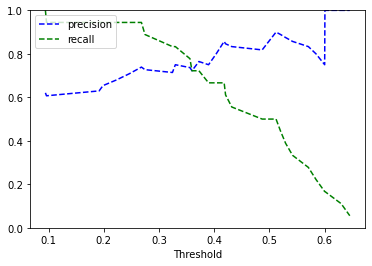

In [25]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(precision, recall, thresholds)
plt.show()

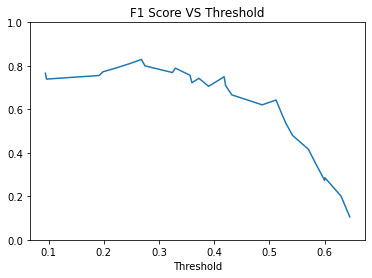

In [35]:
def F1Score_vs_tresh(precisions, recalls, thresholds):
    F1_score_array = []
    for (pre, rec) in zip(precision[:-1], recall[:-1]):
        F1_score_array.append(calc_f1(pre,rec))
     
    plt.plot(thresholds, F1_score_array)
    plt.xlabel('Threshold')
    plt.ylim([0,1])

F1Score_vs_tresh(precision, recall, thresholds)
plt.title('F1 Score VS Threshold')
plt.show()